In [1]:
using Pkg
Pkg.activate(".")
# Pkg.add(["DataFrames","CSV","FITSIO","Distributions","MultivariateStats","PDMats",Plots","Optim","Interpolations"])
# Pkg.add(["SpecialFunctions", "NLsolve", "QuadGK"])
# Pkg.instantiate()
using CSV
#using FITSIO
using Statistics
using MultivariateStats
using PDMats
using Plots
using Optim
using Interpolations
using LinearAlgebra

SyntaxError: invalid syntax (<ipython-input-1-fcbfe714d36b>, line 1)

In [105]:
function window_function(x::Real)
    exp(-0.5*x^2)/sqrt(2π)
end

function basis_n(x::Real, n::Integer; sinfactor::Real = one(x))
    if n==0         return window_function(x) end
    if mod(n,2)==1  return sin(((n+1)/2)*sinfactor*x) * window_function(x) end
    if mod(n,2)==0  return cos((n/2)*sinfactor*x)     * window_function(x) end
end

basis_n (generic function with 1 method)

In [106]:
x_limit = 3
num_samples = 100
x = range(-x_limit,stop=x_limit,length=num_samples)

-3.0:0.06060606060606061:3.0

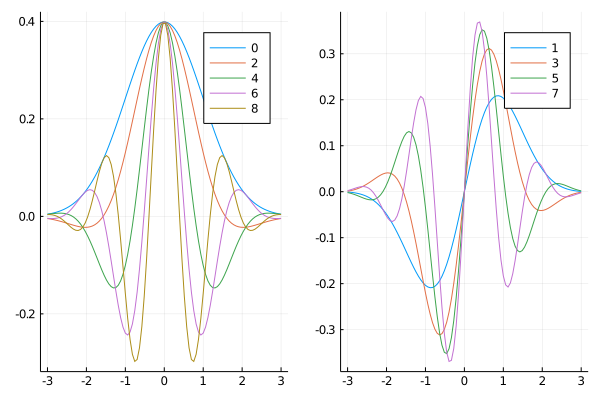

In [107]:
plt1 = plot(x,basis_n.(x,0), label="0")
plt2 = plot(x,basis_n.(x,1), label="1")
plot!(plt1,x,basis_n.(x,2), label="2")
plot!(plt2,x,basis_n.(x,3), label="3")
plot!(plt1,x,basis_n.(x,4), label="4")
plot!(plt2,x,basis_n.(x,5), label="5")
plot!(plt1,x,basis_n.(x,6), label="6")
plot!(plt2,x,basis_n.(x,7), label="7")
plot!(plt1,x,basis_n.(x,8), label="8")
#plot!(plt2,x,basis_n.(x,9), label="9")
#plot!(plt1,x,basis_n.(x,10), label="10")
#plot!(plt2,x,basis_n.(x,0), label="0")
plot(plt1,plt2, layout=2)

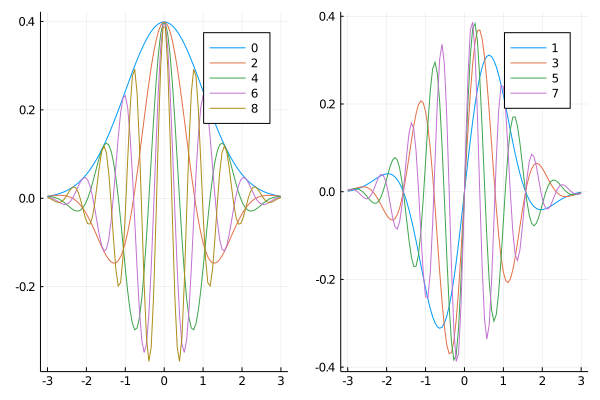

In [110]:
sf = 2
plt1 = plot(x,basis_n.(x,0,sinfactor=sf), label="0")
plt2 = plot(x,basis_n.(x,1,sinfactor=sf), label="1")
plot!(plt1,x,basis_n.(x,2,sinfactor=sf), label="2")
plot!(plt2,x,basis_n.(x,3,sinfactor=sf), label="3")
plot!(plt1,x,basis_n.(x,4,sinfactor=sf), label="4")
plot!(plt2,x,basis_n.(x,5,sinfactor=sf), label="5")
plot!(plt1,x,basis_n.(x,6,sinfactor=sf), label="6")
plot!(plt2,x,basis_n.(x,7,sinfactor=sf), label="7")
plot!(plt1,x,basis_n.(x,8,sinfactor=sf), label="8")
#plot!(plt2,x,basis_n.(x,9), label="9")
#plot!(plt1,x,basis_n.(x,10), label="10")
#plot!(plt2,x,basis_n.(x,0), label="0")
plot(plt1,plt2, layout=2)

In [243]:
function make_basis(x::AbstractArray{T}; x_center = zero(T), x_scale = one(T), degree_poly::Integer = 0, degree_line::Integer = 6) where T<:Real
    num_bases = degree_line
    num_samples = length(x)
    @assert num_bases >= 1
    @assert num_samples > num_bases

    x = (x.- x_center)./x_scale
    b = zeros(num_samples,num_bases)
    #balt = zeros(num_samples,num_bases)
    norm = zeros(num_bases)
    proj = zeros(num_samples)
    b[:,1] .= 1
    #balt[:,1] .= 1
    norm[1] = sum(b[:,1].^2)
    for i in 2:num_bases
        #balt[:,i] .= basis_n.(x,i-2)
        b[:,i] .= basis_n.(x,i-2,sinfactor=2)
        norm[i] = sum(b[:,i].^2)
        if i>1
            for j = 1:(i-1)
                proj .= ((b[:,i].*b[:,j])/norm[j]) .* b[:,j]
                b[:,i] .-= proj
            end
        end
    end
    return b # (b,balt)
end

make_basis (generic function with 2 methods)

In [292]:
x_limit = 4
x = range(-x_limit,stop=x_limit,length=100)
b = make_basis(x, degree_line=10)

100×10 Array{Float64,2}:
 1.0  0.000132492   0.000111716   7.12302e-5   …  -0.000101365  -8.53179e-5
 1.0  0.000182452   0.00016341    8.11537e-5      -0.000175696  -4.91898e-5
 1.0  0.000249617   0.000234115   8.65953e-5      -0.000246675   3.82116e-5
 1.0  0.000339283   0.000328935   8.31543e-5      -0.000283732   0.000186035
 1.0  0.000458157   0.000453614   6.4361e-5       -0.000244831   0.000387253
 1.0  0.000614654   0.000614293   2.10648e-5   …  -8.40117e-5    0.000608885
 1.0  0.00081924    0.000817094  -5.92521e-5       0.000233914   0.000785134
 1.0  0.00108481    0.00106747   -0.000193206      0.000712222   0.000818264
 1.0  0.00142713    0.00136927   -0.000402237      0.00129845    0.00059221
 1.0  0.00186525    0.00172348   -0.000713263      0.00186523    2.31364e-6
 1.0  0.002422      0.00212659   -0.00115915   …   0.00220608   -0.000999565
 1.0  0.00312446    0.00256858   -0.00177891       0.00205713   -0.0023516
 1.0  0.00400442    0.00303054   -0.00261743       0.00115

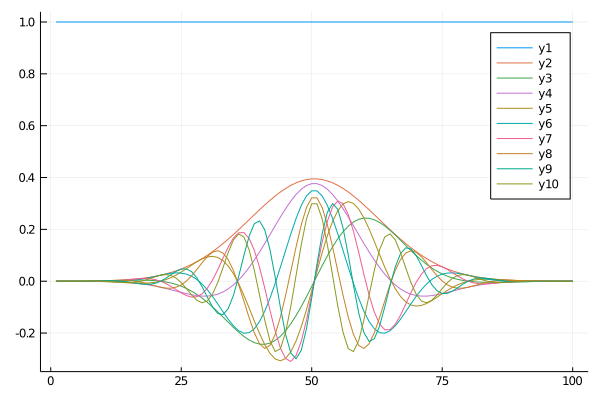

In [293]:
plot(b)

In [294]:
function eval_lsf(x::Real; a::AbstractArray, x_center = zero(T), x_scale = one(T), degree_poly::Integer = 0, degree_line::Integer = 0) where T<:Real
    @assert -10 <= x_center <= 10
    @assert 0 < x_scale < 100
    @assert 0 <= degree_poly <= 2
    @assert 0 <= degree_line <= 8
    x = (x - x_center) / x_scale
    basis_comb = zeros(Float64,2+degree_poly+degree_line)
    basis_comb[1] = one(x)
    if degree_poly >= 1 
        for i in 2:degree_poly+1
            basis_comb[i] = x.^(i-1)
        end
    end
    for i in (2+degree_poly):(2+degree_poly+degree_line)
        basis_comb[i] = basis_n(x,i-2-degree_poly)
    end
    return basis_comb' * a
end


eval_lsf (generic function with 1 method)

In [295]:
function fit_and_predict(θ; x::AbstractArray, yobs::AbstractArray, sigmaobs::AbstractArray, degree_poly::Integer = 0, degree_line::Integer = 1)
    x_center = θ[1]
    x_scale = abs(θ[2])
    #=
    @assert -3 <= x_center <= 3
    @assert 0 < x_scale < 100
    @assert 0 <= degree_poly <= 2
    @assert 0 <= degree_line <= 8
    x = (x .- x_center) ./ x_scale
    basis = zeros(Float64,length(x),2+degree_poly+degree_line)
    basis[:,1] .= ones(length(x))
    if degree_poly >= 1 
        for i in 2:degree_poly+1
            basis[:,i] .= ((x.-x[1])./(x[end]-x[1]).-0.5).^(i-1)
        end
    end
    for i in (2+degree_poly):(2+degree_poly+degree_line)
        basis[:,i] .= hermite_n.(x,i-2-degree_poly)
    end
    =#
    basis = make_basis(x, x_center=x_center, x_scale=x_scale, degree_poly=degree_poly, degree_line=degree_line)
    #a = llsq(basis, yobs; bias=false)
    X = basis
    #a = (X' * X) \ (X' * yobs)  # unweighted
    
    Winv = PDiagMat(sigmaobs.^2)
    #println("eigs = ", eigvals(Xt_invA_X(Winv, X)))
    a = Xt_invA_X(Winv, X)  \ (X' * (inv(Winv) * yobs) )
    pred = ( basis * a )
    return pred,a
end

fit_and_predict (generic function with 1 method)

In [296]:
function predict(θ; a::AbstractArray, x::AbstractArray, degree_poly::Integer = 0, degree_line::Integer = 0)
    x_center = θ[1]
    x_scale = abs(θ[2])
    basis = make_basis(x, x_center=x_center, x_scale=x_scale, degree_poly=degree_poly, degree_line=degree_line)
    pred = (basis * a ) 
    return pred
end

predict (generic function with 1 method)

In [297]:
function calc_rms_error(ypred,yobs)
    rmse = sqrt(Statistics.mean(abs2.(ypred .- yobs)))
end
function calc_chi_sq(ypred,yobs,sigmaobs)
    sum(abs.( (ypred .- yobs).^2 ./ sigmaobs.^2 ))
end

calc_chi_sq (generic function with 1 method)

In [298]:
function find_cols_to_fit(wavelengths::AbstractArray{T,1}, line_center::Real; Δ::Real = 0.3) where T<:Real
    findfirst(x->x>=line_center-Δ,wavelengths):findlast(x->x<=line_center+Δ,wavelengths)
end

function find_cols_to_fit(wavelengths::AbstractArray{T,1}, line_lo::Real, line_hi::Real) where T<:Real
    @assert line_lo < line_hi
    findfirst(x->x>=line_lo,wavelengths):findlast(x->x<=line_hi,wavelengths)
end

find_cols_to_fit (generic function with 2 methods)

In [299]:
function fit_line_profile(xobs,yobs,sigmaobs; θ_init, width_default::Real = zero(eltype(θ_init)), max_degree_line::Integer=4, degree_poly::Integer=1, make_plot::Bool = true)
    @assert 0 <= max_degree_line <= 8
    @assert 0 <= degree_poly <= 2
    @assert size(xobs) == size(yobs) == size(sigmaobs)
    @assert 1 <= length(θ_init) <= 2
    initial_θ = θ_init
    local ypred, coeff, res
    if make_plot plt = scatter(xobs,yobs,label="Obs",legend=:bottomright) end
    #plt = scatter(xobs,yobs,label="Obs",legend=:topright)
    width_init = width_default == zero(width_default) ? θ_init[2] : width_default 
    deg_line = 0
    function helper_fixed_width(θ)
        θtmp = [ θ[1], width_init ]
        ypred, coeff = fit_and_predict(θtmp, x=xobs, yobs=yobs,sigmaobs=sigmaobs,degree_line=deg_line,degree_poly=degree_poly)
        calc_chi_sq(ypred,yobs,sigmaobs)
    end
    res = optimize(helper_fixed_width, [initial_θ[1] ], Newton())
    #res = optimize(helper, initial_θ)
    println("Degree = 0 (fixed width): χ^2 = ", res.minimum, "  RMS = ",calc_rms_error(ypred,yobs) )    
    initial_θ = vcat(res.minimizer, [width_init])
    (ypred, coeff) = fit_and_predict(initial_θ, x=xobs, yobs=yobs,sigmaobs=sigmaobs, degree_line=deg_line,degree_poly=degree_poly)
    println("   arg = ", res.minimizer, " a = ", coeff)
    if make_plot 
        plot!(plt,xobs,ypred,label="Fixed width")
    end
    for deg_line in 0:max_degree_line
        function helper(θ)
            ypred, coeff = fit_and_predict(θ, x=xobs, yobs=yobs,sigmaobs=sigmaobs,degree_line=deg_line,degree_poly=degree_poly)
            calc_chi_sq(ypred,yobs,sigmaobs)
        end
        
        res = optimize(helper, initial_θ)
        println("Degree = ", deg_line, ": χ^2 = ", res.minimum, "  RMS = ",calc_rms_error(ypred,yobs) )    
        initial_θ = res.minimizer
        (ypred, coeff) = fit_and_predict(initial_θ, x=xobs, yobs=yobs,sigmaobs=sigmaobs, degree_line=deg_line,degree_poly=degree_poly)
        println("   arg = ", res.minimizer, " a = ", coeff)
        if make_plot 
            plot!(plt,xobs,ypred,label=string(deg_line))
        end
    end 
    if make_plot 
        flush(stdout)
        display(plt)
    end
    return (res.minimizer, coeff, ypred)
end


fit_line_profile (generic function with 1 method)

In [300]:
using Interpolations

AF = Real # AbstractFloat
AA = AbstractArray

function measure_bisector(xs::AA{T,1}, ys::AA{T,1}; interpolate::Bool=true,
                          top::T=0.99, len::Integer=100) where T<:AF
    if interpolate
        return measure_bisector_interpolate(xs, ys, top=top, len=len)
    else
        return measure_bisector_loop(xs, ys, top=top, len=len)
    end
end

function measure_bisector_interpolate(xs::AA{T,1}, ys::AA{T,1}; top::T=0.99,
                                      len::Integer=100) where T<:AF
    # check lengths and normalization
    @assert length(xs) == length(ys)

    # normalize the spec, find bottom of line
    ys ./= maximum(ys)
    botind = argmin(ys)
    depths = range(ys[botind], top, length=len)

    # find left and right halves
    lind = findfirst(ys .< top)
    rind = findlast(ys .< top)
    lspec = reverse(ys[lind:botind])
    rspec = ys[botind:rind]
    lwav = reverse(xs[lind:botind])
    rwav = xs[botind:rind]

    # interpolate wavelengths onto intensity grid
    lspline = LinearInterpolation(lspec, lwav, extrapolation_bc=Flat())
    rspline = LinearInterpolation(rspec, rwav, extrapolation_bc=Flat())
    w1 = lspline(depths)
    w2 = rspline(depths)
    wavs = (lspline(depths) .+ rspline(depths)) ./ 2.0
    return wavs, depths
end

function measure_bisector_loop(xs::AA{T,1}, ys::AA{T,1}; top::T=0.99,
                               len::Integer=100) where T<:AF
    # normalize the spec, find bottom of line
    ys ./= maximum(ys)

    # assign depths to measure bisector at
    dep = range(one(T)-minimum(ys)-0.01, one(T) - top, length=len)

    # set iterators
    nccf = Int(length(xs) ÷ 2)
    L = nccf
    R = nccf

    # allocate memory
    xL = zeros(len)
    xR = zeros(len)
    wav = zeros(len)

    # loop over depths
    for d in eachindex(dep)
        y = 1 - dep[d]
        while((ys[L] < y) & (L > 0))
            L -= 1
        end

        while ((ys[R] < y) & (R < length(xs)))
            R += 1
        end

        if ((y > maximum(ys[1:nccf])) | (y > maximum(ys[nccf+1:end])))
            L = 0
            R = length(xs)
        end

        if L == 0
            xL[d] = xL[d-1]
        else
            mL = (xs[L+1] - xs[L]) / (ys[L+1] - ys[L])
            xL[d] = xs[L] + mL * (y - ys[L])
        end

        if R == length(xs)
            xR[d] = xR[d-1]
        else
            mR = (xs[R-1] - xs[R]) / (ys[R-1] - ys[R])
            xR[d] = xs[R] + mR * (y - ys[R])
        end
        wav[d] = (xL[d] + xR[d]) / 2.0
    end
    return wav, one(T) .- dep
end

measure_bisector_loop (generic function with 1 method)

In [51]:
using CSV
df = CSV.read("../feI5434_spectra_bisectors/spectra_for_eric.csv")
sol_flux, sol_var, sol_wave = df[:,2], 0.001.*df[:,2], df[:,1]

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], [5434.0, 5434.007762857143, 5434.015525714286, 5434.023288571429, 5434.031051428571, 5434.038814285715, 5434.046577142857, 5434.05434, 5434.062102857143, 5434.069865714286  …  5434.92378, 5434.931542857143, 5434.939305714286, 5434.947068571429, 5434.954831428571, 5434.962594285715, 5434.970357142857, 5434.97812, 5434.985882857143, 5434.993645714286])

In [373]:
line_center = 5434.5
delta_lambda_fit = 0.35
idx_cols = find_cols_to_fit(sol_wave,line_center,Δ=delta_lambda_fit)

21:110

In [374]:
using Interpolations

AF = Real # AbstractArray
AA = AbstractArray

function measure_bisector(xs::AA{T,1}, ys::AA{T,1}; interpolate::Bool=true,
                          top::T=0.99, len::Integer=100) where T<:AF
    if interpolate
        return measure_bisector_interpolate(xs, ys, top=top, len=len)
    else
        return measure_bisector_loop(xs, ys, top=top, len=len)
    end
end

function measure_bisector_interpolate(xs::AA{T,1}, ys::AA{T,1}; top::T=0.99,
                                      len::Integer=100) where T<:AF
    # check lengths and normalization
    @assert length(xs) == length(ys)

    # normalize the spec, find bottom of line
    ys ./= maximum(ys)
    botind = argmin(ys)
    depths = range(ys[botind], top, length=len)

    # find left and right halves
    lind = findfirst(ys .< top)
    rind = findlast(ys .< top)
    lspec = reverse(ys[lind:botind])
    rspec = ys[botind:rind]
    lwav = reverse(xs[lind:botind])
    rwav = xs[botind:rind]

    # interpolate wavelengths onto intensity grid
    lspline = LinearInterpolation(lspec, lwav, extrapolation_bc=Flat())
    rspline = LinearInterpolation(rspec, rwav, extrapolation_bc=Flat())
    w1 = lspline(depths)
    w2 = rspline(depths)
    wavs = (lspline(depths) .+ rspline(depths)) ./ 2.0
    return wavs, depths
end

function measure_bisector_loop(xs::AA{T,1}, ys::AA{T,1}; top::T=0.99,
                               len::Integer=100) where T<:AF
    # normalize the spec, find bottom of line
    ys ./= maximum(ys)

    # assign depths to measure bisector at
    dep = range(one(T)-minimum(ys)-0.01, one(T) - top, length=len)

    # set iterators
    nccf = Int(length(xs) ÷ 2)
    L = nccf
    R = nccf

    # allocate memory
    xL = zeros(len)
    xR = zeros(len)
    wav = zeros(len)

    # loop over depths
    for d in eachindex(dep)
        y = 1 - dep[d]
        while((ys[L] < y) & (L > 0))
            L -= 1
        end

        while ((ys[R] < y) & (R < length(xs)))
            R += 1
        end

        if ((y > maximum(ys[1:nccf])) | (y > maximum(ys[nccf+1:end])))
            L = 0
            R = length(xs)
        end

        if L == 0
            xL[d] = xL[d-1]
        else
            mL = (xs[L+1] - xs[L]) / (ys[L+1] - ys[L])
            xL[d] = xs[L] + mL * (y - ys[L])
        end

        if R == length(xs)
            xR[d] = xR[d-1]
        else
            mR = (xs[R-1] - xs[R]) / (ys[R-1] - ys[R])
            xR[d] = xs[R] + mR * (y - ys[R])
        end
        wav[d] = (xL[d] + xR[d]) / 2.0
    end
    return wav, one(T) .- dep
end

measure_bisector_loop (generic function with 1 method)

RMS = 0.0004917069115081206 χ^2 = 30.96940348225999 dof = 90
coeff = [9.477328635316105, -2.0165954626250775, -0.42574651545162917, -1.0909891027898662, -0.05391600178181281, -0.04023317845286138, 0.008419181709876704, 0.03217307605523395, 0.017955439845497082, 0.032063939282573645, 0.018998688070941825, 0.010204085511527914, 0.004857092814166464, -0.003577217416265557]


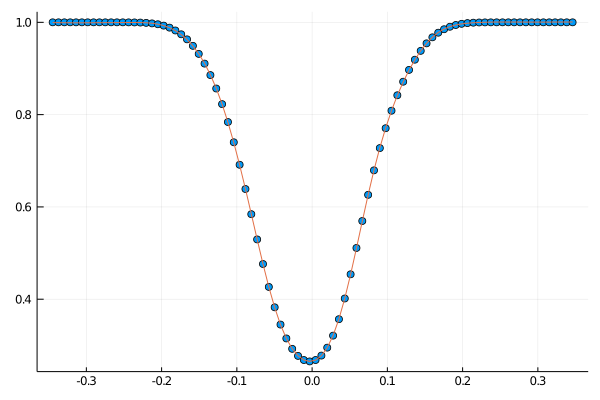

In [375]:
θ_init = [-0.02, 0.1]
xobs = sol_wave[idx_cols] .- line_center 
yobs = convert(Array{Float64,1},sol_flux[idx_cols] )
sigmaobs = convert(Array{Float64,1},sol_var[idx_cols] )
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=14)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
scatter(xobs,yobs,legend=:none)
plot!(xobs,ypred,legend=:none)

In [452]:
function make_basis(x::AbstractArray{T}; x_center = zero(T), x_scale = one(T), degree_poly::Integer = 0, degree_line::Integer = 6) where T<:Real
    num_bases = degree_line
    num_samples = length(x)
    @assert num_bases >= 1
    @assert num_samples > num_bases

    x = (x.- x_center)./x_scale
    b = zeros(num_samples,num_bases)
    #balt = zeros(num_samples,num_bases)
    norm = zeros(num_bases)
    proj = zeros(num_samples)
    b[:,1] .= 1
    #balt[:,1] .= 1
    norm[1] = b[:,1]'*b[:,1]
    b[:,1] ./= sqrt(norm[1])
    for i in 2:num_bases
        #balt[:,i] .= basis_n.(x,i-2)
        b[:,i] .= basis_n.(x,i-2,sinfactor=1.32)
        if i>1
            for j = 1:(i-1)
                proj .= ((b[:,i]'*b[:,j])/norm[j]) .* b[:,j]
                b[:,i] .-= proj
                norm[i] = b[:,i]'*b[:,i]
            end
        end
        norm[i] = b[:,i]'*b[:,i]
        b[:,i] ./= sqrt(norm[i]) # b[:,i]'*b[:,i])
    end
    return b # (b,balt)
end

make_basis (generic function with 2 methods)

RMS = 0.00652779802791285 χ^2 = 12720.838131842977 dof = 90
coeff = [9.442905347345619, -1.9213375224592795, -0.42915294067953136, -1.1718786908909626, -0.047373289142698435, 0.02309004184755091]
RMS = 0.0050014447625023216 χ^2 = 5509.040052163192 dof = 90
coeff = [9.49792552373599, -2.078769426894074, -0.42256097267295806, -1.0401144112486924, -0.055642603466154246, -0.0641230886223516, 0.020674747017377176, 0.06418916899472733]
RMS = 0.0026598928686437737 χ^2 = 1222.4949286422784 dof = 90
coeff = [9.471706417613266, -1.9993611037191001, -0.4291051860543381, -1.1060677786429371, -0.05290637461314526, -0.033569092518245164, 0.012085517681737063, 0.03214575325005125, 0.02706044911338649, 0.038372379870227236]
RMS = 0.0007628618385327215 χ^2 = 105.04068363370794 dof = 90
coeff = [9.476304975745666, -2.0134313689554832, -0.42518779981049964, -1.0937196460713392, -0.054325288472099185, -0.038894204741595585, 0.00762394053057575, 0.03199502813662013, 0.01968248155321419, 0.03142219798441047

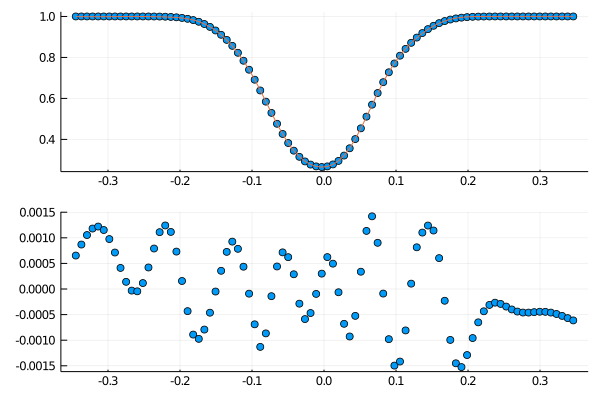

In [457]:
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=6)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=8)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=10)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=12)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
#=
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=14)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=10)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)

(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=18)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=0, degree_line=20)
println("RMS = ",calc_rms_error(ypred,yobs), " χ^2 = ", calc_chi_sq(ypred,yobs,sigmaobs), " dof = ", length(xobs))
println("coeff = ", coeff)
=#
plt1 = scatter(xobs,yobs,legend=:none)
plot!(plt1, xobs,ypred,legend=:none)
plt2 = scatter(xobs, yobs.-ypred,legend=:none)
plot(plt1,plt2,layout=(2,1))

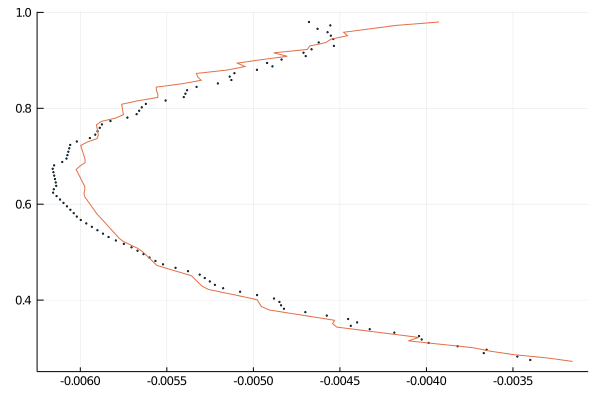

In [458]:
i = 2
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
(ypred, coeff) = fit_and_predict(θ_init, x=xobs, yobs=yobs, sigmaobs=sigmaobs, degree_poly=1, degree_line=length(coeff)-2)
#yobs_recon = predict(coeff[1:2], a=coeff[3:end], x=xobs, degree_line=length(coeff)-2)
bis_fit = measure_bisector(xobs,ypred , interpolate=false, top=0.98)
scatter(bis_obs[1],bis_obs[2], ms=1, label="Observed" * string(i), legend=:none)
plot!(bis_fit[1],bis_fit[2], label="Reconstructed")

In [451]:
#=
i = 20
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
yobs_recon = predict(Xr[1:2,i], a=Xr[3:end,i], x=xobs, degree_line=max_deg)
bis_fit = measure_bisector(xobs,yobs_recon , interpolate=false, top=0.96)
scatter!(bis_obs[1],bis_obs[2], ms=1, label="Observed " * string(i))
plot!(bis_fit[1],bis_fit[2], label="Reconstructed "* string(i))
i = 40
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
yobs_recon = predict(Xr[1:2,i], a=Xr[3:end,i], x=xobs, degree_line=max_deg)
bis_fit = measure_bisector(xobs,yobs_recon , interpolate=false, top=0.96)
scatter!(bis_obs[1],bis_obs[2], ms=1, label="Observed " * string(i))
plot!(bis_fit[1],bis_fit[2], label="Reconstructed "* string(i))
i = 60
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
yobs_recon = predict(Xr[1:2,i], a=Xr[3:end,i], x=xobs, degree_line=max_deg)
#bis_fit4 = measure_bisector(xobs,yobs_recon , interpolate=false, top=0.98)
scatter!(bis_obs[1],bis_obs[2], ms=1, label="Observed " * string(i))
plot!(bis_fit4[1],bis_fit4[2], label="Reconstructed "* string(i))
i = 80
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
yobs_recon = predict(Xr[1:2,i], a=Xr[3:end,i], x=xobs, degree_line=max_deg)
#bis_fit5 = measure_bisector(xobs,yobs_recon , interpolate=false, top=0.98)
scatter!(bis_obs[1],bis_obs[2], ms=1, label="Observed " * string(i))
plot!(bis_fit5[1],bis_fit5[2], label="Reconstructed "* string(i))
i = 100
bis_obs = measure_bisector(xobs,df[idx_cols,i] , interpolate=false, top=0.98)
yobs_recon = predict(Xr[1:2,i], a=Xr[3:end,i], x=xobs, degree_line=max_deg)
#bis_fit6 = measure_bisector(xobs,yobs_recon , interpolate=false, top=0.98)
scatter!(bis_obs[1],bis_obs[2], ms=1, label="Observed " * string(i))
plot!(bis_fit6[1],bis_fit6[2], label="Reconstructed "* string(i))
=#
